# EDA: Mental Health Risk & Disclosure (OSMI Tech Survey

## Problem Statement
How can tech companies identify which groups of employees are at highest risk for mental health challenges post-pandemic, **predict their likelihood of disclosure**, and **design targeted wellness interventions**—while safeguarding privacy and overcoming stigma?

**Success Criteria**
- Build a disclosure prediction model with ≥75% accuracy (later steps).  
- Identify 3–5 actionable **employee personas** based on risk & disclosure likelihood.  
- Deliver dashboards for HR to explore patterns by demographics, benefits, and culture.

This notebook performs **Exploratory Data Analysis (EDA)** to find the strongest drivers of:
- **(A) Mental health condition / treatment** (risk proxy)  
- **(B) Willingness to disclose** (disclosure proxy)

Each code block is followed by a short **Mentor Summary**.


# Setup & Load

In [9]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


data_path_candidates = [
    Path("survey_clean_final.csv"),
    Path("survey_clean.csv"),
    Path("survey.csv"),
    Path("/mnt/data/survey.csv")
]


for p in data_path_candidates:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError("Could not find a survey CSV. Put it next to this notebook or update data_path.")

df = pd.read_csv(data_path, low_memory=False)
print("Loaded:", data_path.resolve())
print("Shape:", df.shape)
df.head(10)

Loaded: /Users/mariaalejandrasuarez/Documents/Capstone 3/survey_clean_final.csv
Shape: (1259, 27)


,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31+00:00,37.0,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37+00:00,44.0,Male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44+00:00,32.0,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46+00:00,31.0,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22+00:00,31.0,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22+00:00,33.0,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN
6,2014-08-27 11:31:50+00:00,35.0,Female,United States,MI,NaN,Yes,Yes,Sometimes,1-5,...,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No,NaN
7,2014-08-27 11:32:05+00:00,39.0,Male,Canada,NaN,NaN,No,No,Never,1-5,...,Don't know,No,No,No,No,No,No,No,No,NaN
8,2014-08-27 11:32:39+00:00,42.0,Female,United States,IL,NaN,Yes,Yes,Sometimes,100-500,...,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
9,2014-08-27 11:32:43+00:00,23.0,Male,Canada,NaN,NaN,No,No,Never,26-100,...,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN


# Ensure readable column names

In [10]:
def clean_colname(c):
    c = str(c).strip().lower()
    c = c.replace("/", " ").replace("\n", " ").replace("-", " ")
    c = " ".join(c.split())
    c = c.replace("%", "pct")
    c = "".join(ch if ch.isalnum() or ch==" " else "_" for ch in c)
    c = "_".join(c.split())
    while "__" in c:
        c = c.replace("__", "_")
    return c

orig = df.columns.tolist()
df.columns = [clean_colname(c) for c in df.columns]

print("Columns cleaned. Example mapping (first 10):")
for o, n in zip(orig[:10], df.columns[:10]):
    print(f"  {o} -> {n}")

Columns cleaned. Example mapping (first 10):
  timestamp -> timestamp
  age -> age
  gender -> gender
  country -> country
  state -> state
  self_employed -> self_employed
  family_history -> family_history
  treatment -> treatment
  work_interfere -> work_interfere
  no_employees -> no_employees


# Locate key variables (risk & disclosure)

In [11]:
def find_cols(df, needles):
    found = {}
    for n in needles:
        matches = [c for c in df.columns if n in c]
        if matches: found[n] = matches
    return found

needles = [
    "treat", "diagnos", "mental", "condition",         # risk/condition
    "disclos", "supervisor", "coworker", "interview",   # disclosure intent
    "benefit", "care_option", "anonym", "seek", "leave",
    "no_employees", "company", "remote", "work",
    "age", "gender", "country"
]

found = find_cols(df, needles)
for k, v in found.items():
    print(f"{k:>12}: {v}")

       treat: ['treatment']
      mental: ['mental_health_consequence', 'mental_health_interview', 'mental_vs_physical']
  supervisor: ['supervisor']
    coworker: ['coworkers']
   interview: ['mental_health_interview', 'phys_health_interview']
     benefit: ['benefits']
 care_option: ['care_options']
      anonym: ['anonymity']
        seek: ['seek_help']
       leave: ['leave']
no_employees: ['no_employees']
     company: ['tech_company']
      remote: ['remote_work']
        work: ['work_interfere', 'remote_work', 'coworkers']
         age: ['age']
      gender: ['gender']
     country: ['country']


# Create target proxies (risk & disclosure)

In [12]:
YES = {"yes","y","true","1"}
NO = {"no","n","false","0"}

def to_yes_no(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in YES: return "Yes"
    if s in NO:  return "No"
    # keep common OSMI values
    if s in {"maybe","some of them","depends"}: return s.title()
    return x


risk_candidates = [c for c in df.columns if any(k in c for k in ["treat","diagnos","condition"])]
risk_col = None
for c in risk_candidates:
    # pick the most plausible categorical yes/no-like column
    vals = df[c].dropna().astype(str).str.lower().unique()
    if any(v in vals for v in ["yes","no","true","false"]):
        risk_col = c
        break
if risk_col is None and risk_candidates:
    risk_col = risk_candidates[0]  # fallback

if risk_col is not None:
    df["has_condition"] = df[risk_col].map(to_yes_no)
else:
    df["has_condition"] = np.nan


disclose_candidates = [c for c in df.columns if any(k in c for k in ["supervisor","coworker","disclos","interview"])]
disclose_cols = disclose_candidates

def is_yes(x):
    return str(x).strip().lower() in YES or str(x).strip().lower()=="yes"

if disclose_cols:
    any_yes = np.zeros(len(df), dtype=bool)
    for c in disclose_cols:
        any_yes |= df[c].apply(is_yes).fillna(False).values
    df["disclose_yes"] = np.where(any_yes, "Yes", "No")
else:
    df["disclose_yes"] = np.nan

print("Risk proxy column used:", risk_col)
print("Disclosure-related columns used:", disclose_cols[:5])
df[["has_condition","disclose_yes"]].head(10)

Risk proxy column used: treatment
Disclosure-related columns used: ['coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview']


,has_condition,disclose_yes
0,Yes,Yes
1,No,No
2,No,Yes
3,Yes,No
4,No,Yes
5,No,Yes
6,Yes,No
7,No,No
8,Yes,Yes
9,No,Yes


# Overall rates of risk & disclosure

In [14]:
def pct_yes(series):
    vc = series.value_counts(dropna=True)
    yes = vc.get("Yes", 0)
    total = vc.sum()
    return round(100 * yes / total, 1) if total else np.nan

risk_rate = pct_yes(df["has_condition"])
disc_rate = pct_yes(df["disclose_yes"])

print(f"Estimated % with condition/treatment (risk proxy): {risk_rate}%")
print(f"Estimated % willing to disclose (any channel):   {disc_rate}%")

Estimated % with condition/treatment (risk proxy): 50.6%
Estimated % willing to disclose (any channel):   49.7%


# Basic profiles (age, gender, company size)

In [16]:
# Age
if "age" in df.columns:
    print("Age describe:")
    print(df["age"].describe())

# Gender
gcol = "gender" if "gender" in df.columns else None
if gcol:
    print("\nGender value counts (top 10):")
    print(df[gcol].value_counts(dropna=False).head(10))

# Company size
size_candidates = [c for c in df.columns if "no_employees" in c or "company_size" in c or "employees" in c]
size_col = size_candidates[0] if size_candidates else None
if size_col:
    print(f"\nCompany size column: {size_col}")
    print(df[size_col].value_counts(dropna=False))

Age describe:
count    1251.000000
mean       32.076739
std         7.288272
min        18.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: age, dtype: float64

Gender value counts (top 10):
gender
Male                985
Female              249
Non-binary/Other     25
Name: count, dtype: int64

Company size column: no_employees
no_employees
6-25              290
26-100            289
More than 1000    282
100-500           176
1-5               162
500-1000           60
Name: count, dtype: int64


# Disclosure rate by demographics & benefits

In [17]:
def disclosure_rate_by(col):
    tmp = (df.groupby(col)["disclose_yes"]
             .apply(lambda s: (s=="Yes").mean())
             .sort_values(ascending=False)
             .reset_index(name="disclosure_rate"))
    return tmp

tables = {}

# Gender
if "gender" in df.columns:
    tables["by_gender"] = disclosure_rate_by("gender")
    print("\nDisclosure by gender:")
    print(tables["by_gender"].head(10))

# Company size
if size_col:
    tables["by_company_size"] = disclosure_rate_by(size_col)
    print("\nDisclosure by company size:")
    print(tables["by_company_size"])

# Benefits / anonymity / care options
for key in ["benefit","anonym","care_option","seek","leave"]:
    cands = [c for c in df.columns if key in c]
    if cands:
        col = cands[0]
        tables[f"by_{key}"] = disclosure_rate_by(col)
        print(f"\nDisclosure by {col}:")
        print(tables[f"by_{key}"].head(10))


Disclosure by gender:
             gender  disclosure_rate
0  Non-binary/Other         0.520000
1              Male         0.517766
2            Female         0.413655

Disclosure by company size:
     no_employees  disclosure_rate
0            6-25         0.548276
1             1-5         0.524691
2         100-500         0.522727
3          26-100         0.494810
4        500-1000         0.466667
5  More than 1000         0.421986

Disclosure by benefits:
     benefits  disclosure_rate
0         Yes         0.505241
1  Don't know         0.500000
2          No         0.483957

Disclosure by anonymity:
    anonymity  disclosure_rate
0         Yes         0.626667
1  Don't know         0.451770
2          No         0.323077

Disclosure by care_options:
  care_options  disclosure_rate
0          Yes         0.529279
1     Not sure         0.480892
2           No         0.479042

Disclosure by seek_help:
    seek_help  disclosure_rate
0         Yes         0.604000
1          

# Plot a few disclosure comparisons

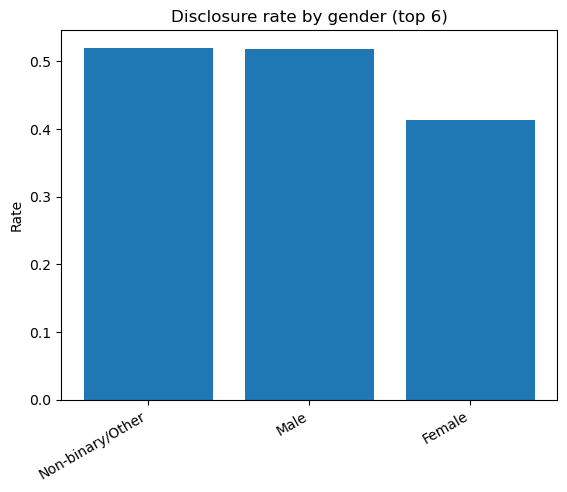

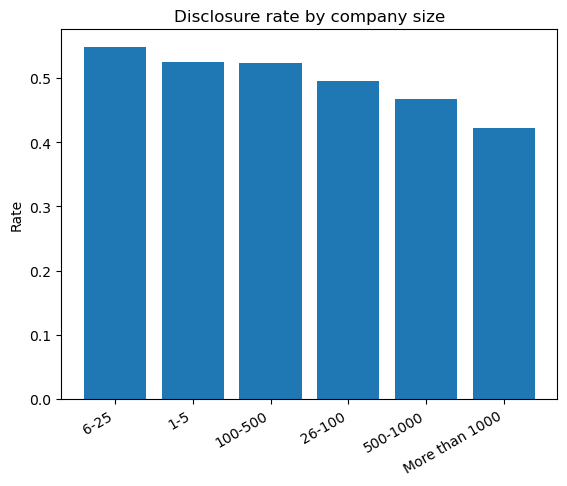

In [18]:
# One chart at a time (matplotlib, no custom colors)

# Example: Top 6 gender groups by disclosure rate
if "by_gender" in locals() or "tables" in locals():
    t = tables.get("by_gender")
    if t is not None and not t.empty:
        t2 = t.head(6)
        plt.figure()
        plt.bar(t2["gender"].astype(str), t2["disclosure_rate"])
        plt.title("Disclosure rate by gender (top 6)")
        plt.xticks(rotation=30, ha="right")
        plt.ylabel("Rate")
        plt.show()

# Example: Company size by disclosure rate
t = tables.get("by_company_size")
if t is not None and not t.empty:
    plt.figure()
    plt.bar(t.iloc[:,0].astype(str), t["disclosure_rate"])
    plt.title("Disclosure rate by company size")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Rate")
    plt.show()

# Disclosure by Gender (with % and counts)

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_32211/4145550150.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, v + 1, f"{v:.1f}%\n(n={gender_n[i]})", ha="center")


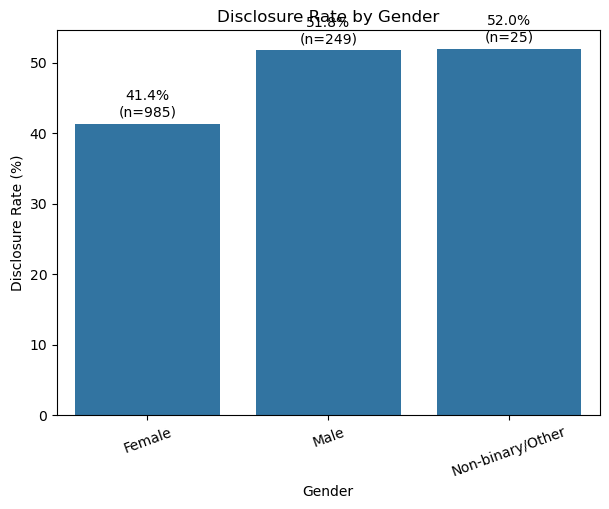

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

gender_counts = df.groupby("gender")["disclose_yes"].value_counts(normalize=True).mul(100).rename("pct").reset_index()
gender_n = df["gender"].value_counts()

plt.figure(figsize=(7,5))
sns.barplot(data=gender_counts[gender_counts["disclose_yes"]=="Yes"], x="gender", y="pct")

for i, v in enumerate(gender_counts[gender_counts["disclose_yes"]=="Yes"]["pct"]):
    plt.text(i, v + 1, f"{v:.1f}%\n(n={gender_n[i]})", ha="center")

plt.title("Disclosure Rate by Gender")
plt.ylabel("Disclosure Rate (%)")
plt.xlabel("Gender")
plt.xticks(rotation=20)
plt.show()

# Histogram & KDE for Age Distribution

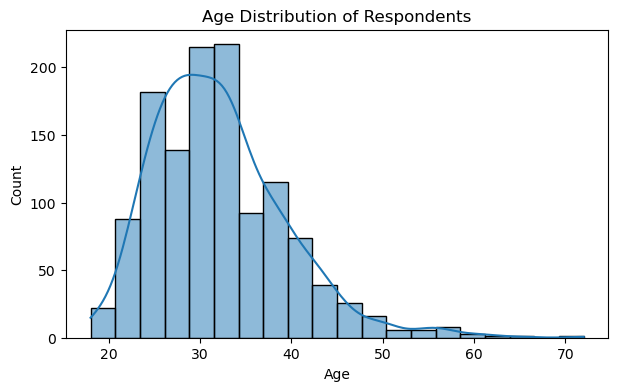

In [21]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(df["age"], bins=20, kde=True)
plt.title("Age Distribution of Respondents")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Boxplot: Age vs. Disclosure

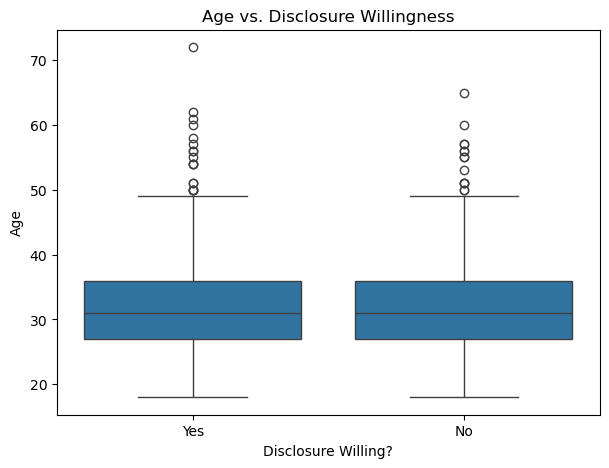

In [22]:
plt.figure(figsize=(7,5))
sns.boxplot(x="disclose_yes", y="age", data=df)
plt.title("Age vs. Disclosure Willingness")
plt.xlabel("Disclosure Willing?")
plt.ylabel("Age")
plt.show()


# Heatmap of Correlations (Numeric Features)

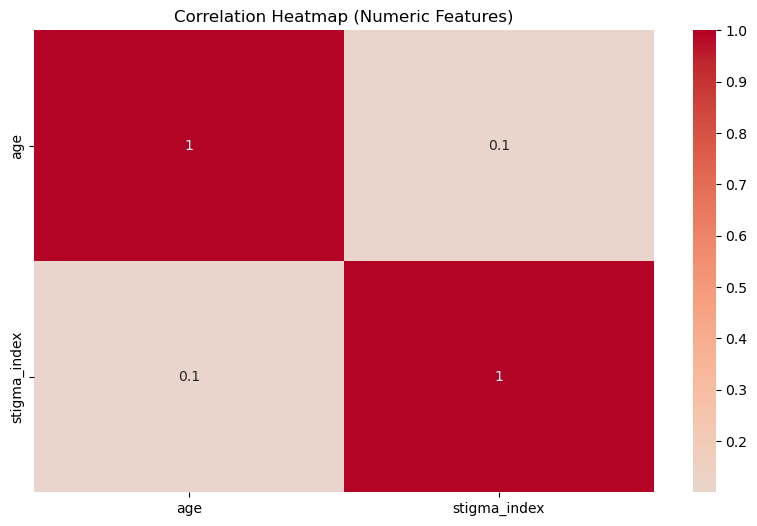

In [23]:
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# Stacked Bar Chart: Benefits vs. Disclosure

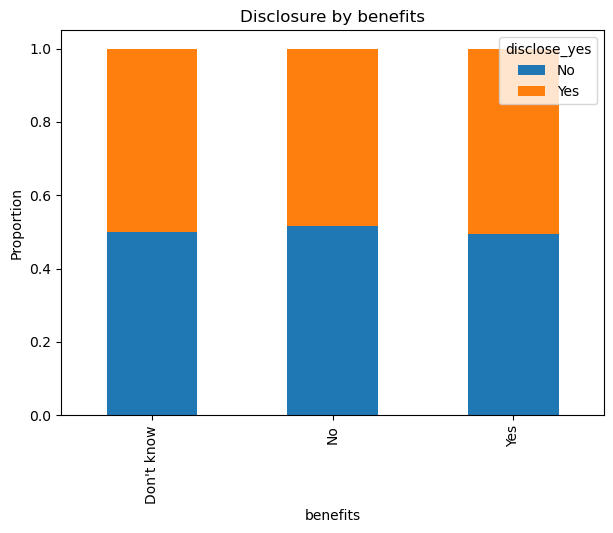

In [24]:
benefit_col = [c for c in df.columns if "benefit" in c][0]  # pick first "benefit" col
cross = pd.crosstab(df[benefit_col], df["disclose_yes"], normalize="index")

cross.plot(kind="bar", stacked=True, figsize=(7,5))
plt.title(f"Disclosure by {benefit_col}")
plt.ylabel("Proportion")
plt.show()

# Disclosure by Company Size (line chart)

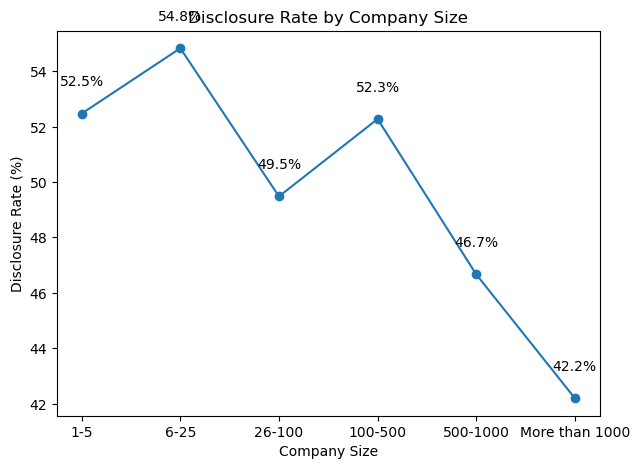

In [30]:
order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
disc_by_size = df.groupby("no_employees")["disclose_yes"].apply(lambda x: (x=="Yes").mean()*100).reindex(order)

plt.figure(figsize=(7,5))
plt.plot(disc_by_size.index, disc_by_size.values, marker="o")
for i, v in enumerate(disc_by_size.values):
    plt.text(i, v+1, f"{v:.1f}%", ha="center")

plt.title("Disclosure Rate by Company Size")
plt.ylabel("Disclosure Rate (%)")
plt.xlabel("Company Size")
plt.show()

# Build a simple Stigma Index (if columns exist)

In [19]:
# Map perception/experience items to 0–1, then average
def map_scale(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    # common OSMI answers
    pos = {"yes","likely","some of them","often"}
    neg = {"no","unlikely","never"}
    mid = {"maybe","sometimes","it depends","depends"}
    if s in pos: return 1.0
    if s in neg: return 0.0
    if s in mid: return 0.5
    return np.nan

stigma_candidates = [c for c in df.columns if any(k in c for k in [
    "mental_health_consequence","phys_health_consequence","mental_vs_physical",
    "observed_consequence","obs_consequence"
])]

if stigma_candidates:
    idx = df[stigma_candidates].applymap(map_scale)
    df["stigma_index"] = idx.mean(axis=1, skipna=True)
    print("Built stigma_index from:", stigma_candidates)
    print(df["stigma_index"].describe())
else:
    print("No obvious stigma-related columns found.")

Built stigma_index from: ['mental_health_consequence', 'phys_health_consequence', 'mental_vs_physical', 'obs_consequence']
count    1259.000000
mean        0.274590
std         0.199399
min         0.000000
25%         0.166667
50%         0.250000
75%         0.375000
max         1.000000
Name: stigma_index, dtype: float64


/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_32211/1390481499.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  idx = df[stigma_candidates].applymap(map_scale)


# Scatterplot: Stigma Index vs. Disclosure Likelihood

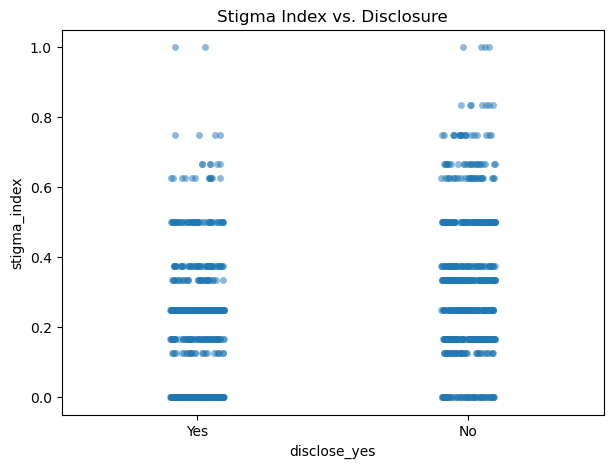

In [26]:
if "stigma_index" in df.columns:
    plt.figure(figsize=(7,5))
    sns.stripplot(x="disclose_yes", y="stigma_index", data=df, jitter=True, alpha=0.5)
    plt.title("Stigma Index vs. Disclosure")
    plt.show()

# Relationship checks (disclosure vs stigma/benefits)

In [20]:
# Compare mean stigma_index by disclosure status (if computed)
if "stigma_index" in df.columns:
    comp = df.groupby("disclose_yes")["stigma_index"].mean().reset_index()
    print("Mean stigma_index by disclosure:")
    print(comp)

# Benefits vs disclosure contingency
benefit_cols = [c for c in df.columns if "benefit" in c]
if benefit_cols:
    col = benefit_cols[0]
    tab = pd.crosstab(df[col], df["disclose_yes"], normalize="index").round(3)
    print(f"\nDisclosure distribution within {col}:")
    print(tab)

Mean stigma_index by disclosure:
  disclose_yes  stigma_index
0           No      0.329055
1          Yes      0.219515

Disclosure distribution within benefits:
disclose_yes     No    Yes
benefits                  
Don't know    0.500  0.500
No            0.516  0.484
Yes           0.495  0.505
